## Testing hypothesis 3
---

**_Hypothesis_**: Reviews with higher book rating have higher helpfulness ratings.

   - **Metric**: Correlation between helpfulness_score book ratings.

**Missing Values**:

  - `review/score`: remove the entire sample
  - `review/helpfulness`: remove the entire sample

**Data Transformation**:
  - `review/score`: groupBy book rating and calculate the average score.
  - `review/helpfulness`: $helpfulness = \frac{x}{y} \sqrt(y)$

---

In [1]:
# Connect to MongoDB

import pymongo

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['books_rating']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy_analyze import *
import seaborn as sns

# Remove the samples which have no score or helpfulness data
pipeline_remove = {'$match':{
                        'review/score':{'$exists':True},
                        'N_helpful'	:{'$exists':True, '$ne':0},
                        'Tot_votes'	:{'$exists':True, '$ne':0}
                        }
    
                }

# Retain only the required fields
pipeline_project = {'$project':{
                            'review/score':1,
                            'review/helpfulness_rate':{'$multiply':[
                                                                {'$divide':['$N_helpful','$Tot_votes']},
                                                                {'$sqrt':'$Tot_votes'}
                                                                ]
                                                       },
                            '_id':0,
                            'Tot_votes':1,
                            'N_helpful':1
                                }
                }   

books_data = books.aggregate([pipeline_remove,pipeline_project])

# Convert into Pandas DataFrame
df_data = pd.DataFrame(list(books_data))
df_data_1 = df_data[df_data['Tot_votes'] == 1]
df_data_1_count = df_data_1.count()[0]

# Check the shape of the data
print(f"The shape of the data is {df_data.shape}")
print(f"The number of samples with only one vote is {df_data_1_count} corresponding to {round(df_data_1_count/df_data.shape[0]*100,2)}% of the total samples.")

The shape of the data is (316203, 4)
The number of samples with only one vote is 52475 corresponding to 16.6% of the total samples.


<AxesSubplot: title={'center': 'Average Helpfulness Rate for each Score'}, xlabel='review/score'>

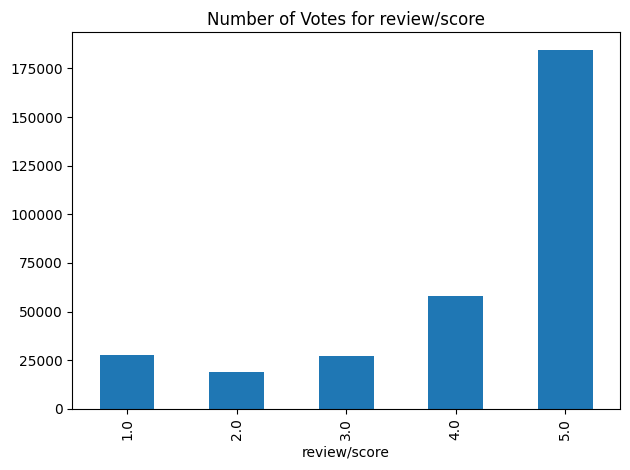

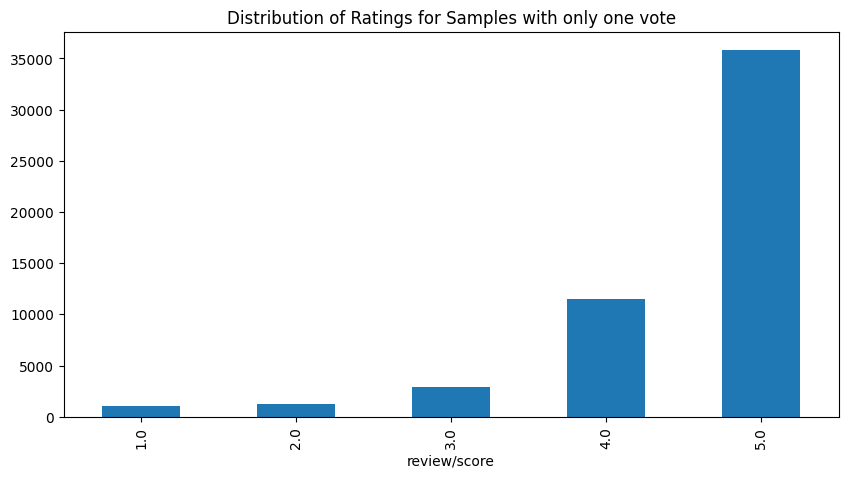

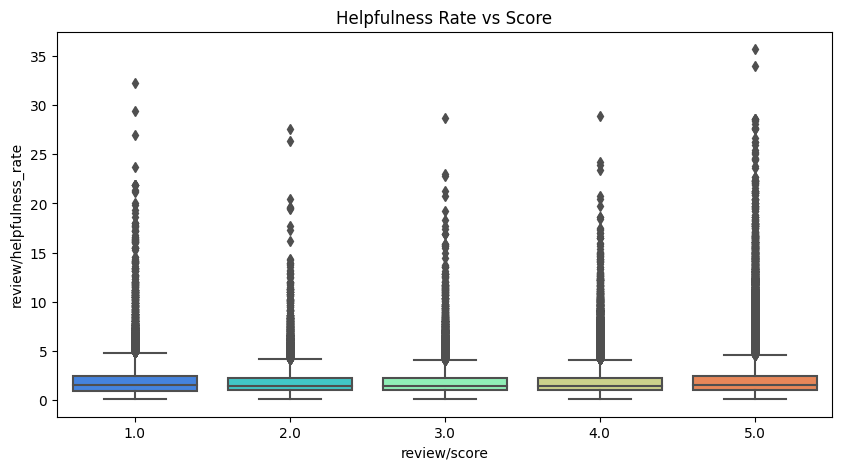

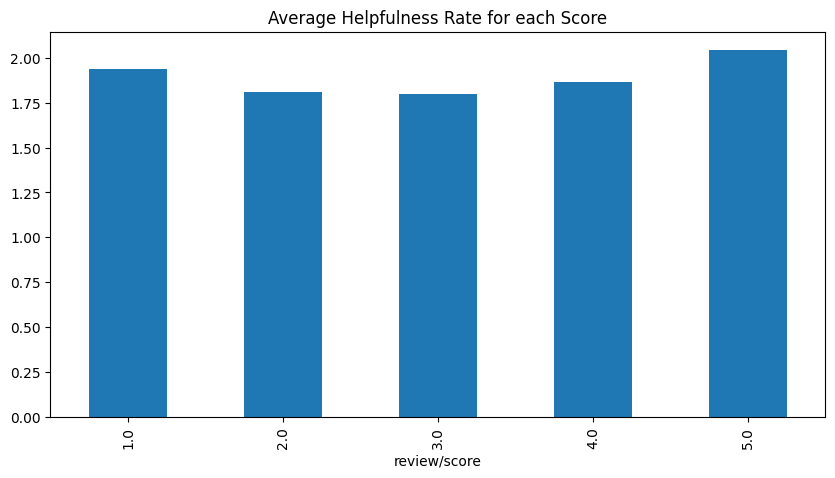

In [3]:
# Compute the distribution of number of votes across rhe review/score
plt.figure()
df_data.groupby('review/score')['Tot_votes'].count().plot(kind='bar', title='Number of Votes for review/score')
plt.tight_layout()
# Compute the distribution of the sample with only one vote on the ratings
plt.figure()
df_data_1.groupby('review/score')['Tot_votes'].count().plot(kind='bar', title='Distribution of Ratings for Samples with only one vote', figsize=(10,5))

# Plot all the data
df_data=df_data[df_data['review/helpfulness_rate'] < 100]
plt.figure(figsize=(10,5))
sns.boxplot(x='review/score', y='review/helpfulness_rate', data=df_data, palette='rainbow')
plt.title('Helpfulness Rate vs Score')
#df_data.plot(kind='scatter', x='review/score', y='review/helpfulness_rate', title='Helpfulness vs Score', figsize=(10,5))

# Compute the average helpfulness rate for each score
plt.figure()
df_grouped_tmp = df_data.groupby('review/score')['review/helpfulness_rate'].mean()
df_grouped_tmp.plot(kind='bar', title='Average Helpfulness Rate for each Score', figsize=(10,5))

### Compute statistics

The statistics are used to numerically asses the results of the hypothesis test.

In [4]:
scipy_analize(df_data['review/score'], 'review/score', df_data['review/helpfulness_rate'], 'review/helpfulness_rate', [1,2,3,4])

The p-value for normality test of review/score is 0.0. The data is not normally distributed.
The p-value for normality test of review/helpfulness_rate is 0.0. The data is not normally distributed.
Since at least one of the variables is not normally distributed, we will use Spearman's correlation.
The p-value for correlation value: 0.06846077338891328 between review/score and review/helpfulness_rate is 0.0. The correlation is significant.
The p-value for Kolmogorov-Smirnov test between review/score and review/helpfulness_rate is 0.0. The two variables do not follow the same distribution.
The p-value for Chi-Square test between review/score and review/helpfulness_rate is 0.0. The two variables are not independent.


---

## Further Analysis on a subset of the data

From the previous analysis the following emerged:
- **Positive Bias**: people are more prone to vote a positive review, indeed there is a correlation between the number of votes and the book rating. Specifically, the number of positive reviews getting a single vote is very high and this might lead to a bias in the helpfulness score, since it is computed by this formula: 

$helpfulness = \frac{x}{y} \sqrt(y)$   where $x$ is the number of positive votes and $y$ is the total number of votes.


To face this problem, we decided to filter the data and consider only the reviews with a number of votes greater than 20.

### - Filtered on number of votes

The shape of the data is (37223, 4)


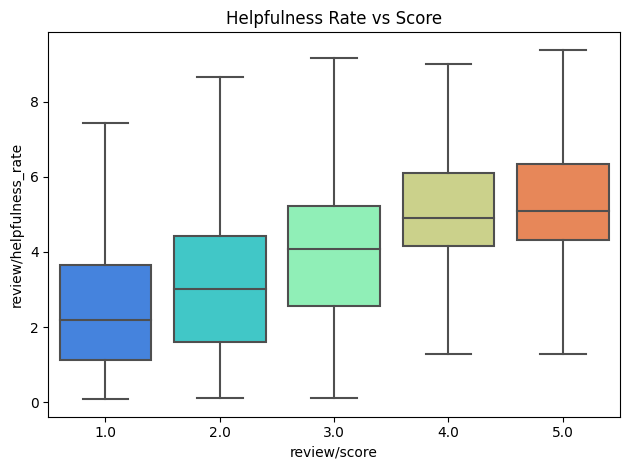

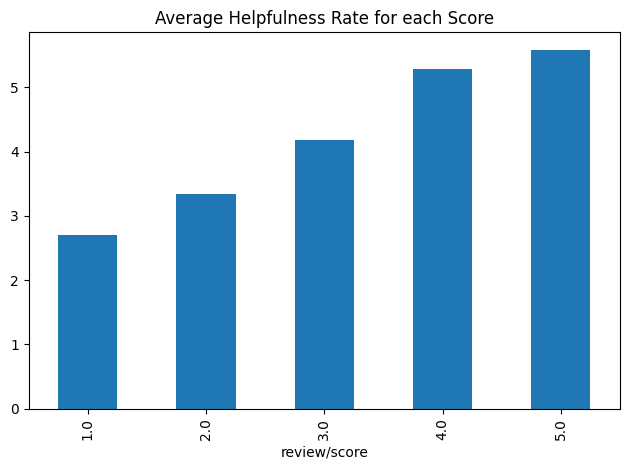

In [5]:
# Remove sample below 100 helpfulness votes
min_votes = 20
filter = df_data['Tot_votes'] > min_votes
df_data_filtered = df_data[filter]

# Check the shape of the data
print(f"The shape of the data is {df_data_filtered.shape}")

# Plot the results
df_data_filtered=df_data_filtered[df_data_filtered['review/helpfulness_rate'] < 100]
plt.figure()
sns.boxplot(x='review/score', y='review/helpfulness_rate', data=df_data_filtered, palette='rainbow', showfliers=False)
plt.title('Helpfulness Rate vs Score')
plt.tight_layout()

#df_data_filtered.plot(kind='scatter', x='review/score', y='review/helpfulness_rate', title='Helpfulness vs Score', figsize=(10,5))

# Compute the average helpfulness rate for each score
plt.figure()
df_data_filtered.groupby('review/score')['review/helpfulness_rate'].mean().plot(kind='bar', title='Average Helpfulness Rate for each Score')
plt.tight_layout()

In [6]:
scipy_analize(df_data_filtered['review/score'], 'review/score', df_data_filtered['review/helpfulness_rate'], 'review/helpfulness_rate', [1,2,3,4])

df_grouped_tmp = df_data_filtered.groupby('review/score')['review/helpfulness_rate'].mean()
df_grouped = pd.DataFrame(df_grouped_tmp).reset_index()

The p-value for normality test of review/score is 0.0. The data is not normally distributed.
The p-value for normality test of review/helpfulness_rate is 0.0. The data is not normally distributed.
Since at least one of the variables is not normally distributed, we will use Spearman's correlation.
The p-value for correlation value: 0.5247190770187261 between review/score and review/helpfulness_rate is 0.0. The correlation is significant.
The p-value for Kolmogorov-Smirnov test between review/score and review/helpfulness_rate is 0.0. The two variables do not follow the same distribution.
The p-value for Chi-Square test between review/score and review/helpfulness_rate is 0.0. The two variables are not independent.


### Results
A positive correlation is present between the book rating and the helpfulness score. 
- `Correlation value`: 0.520716814460294 with `p-value` < 0.05 --> The correlation is significant.
- `Chi-Square test`: 1.6948341620343008e-185 with `p-value` < 0.05 --> Variables are not independent.


To be more precise, it is important to investigate whether the higher value of the helpfulness score is due to the higher number of votes or to the higher number of positive votes.

<AxesSubplot: title={'center': 'Average N_helpful Rate for each Score'}, xlabel='review/score'>

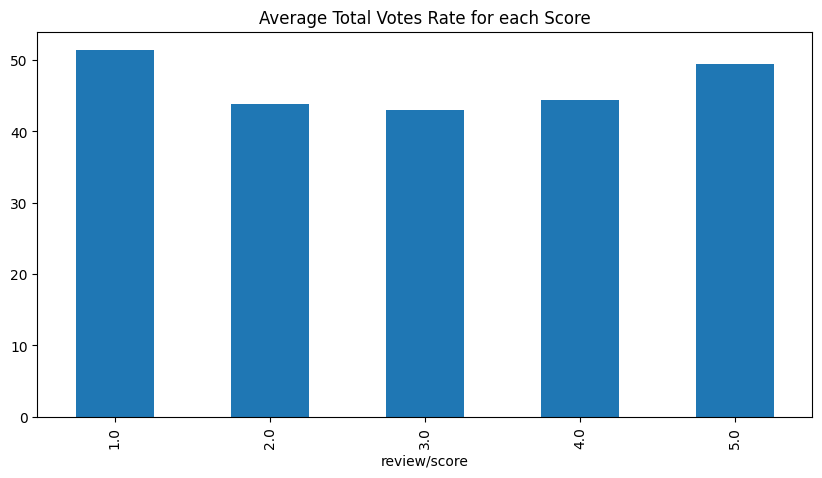

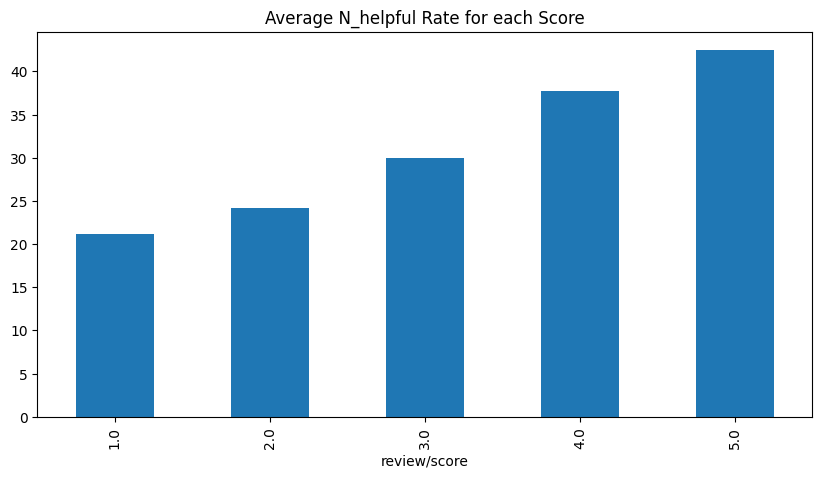

In [7]:
# Compute the average Tot_votes rate for each score
plt.figure()
df_data_filtered.groupby('review/score')['Tot_votes'].mean().plot(kind='bar', title='Average Total Votes Rate for each Score', figsize=(10,5))

# Compute the average N_helpful rate for each score
plt.figure()
df_data_filtered.groupby('review/score')['N_helpful'].mean().plot(kind='bar', title='Average N_helpful Rate for each Score', figsize=(10,5))

## **Conclusions**
#### There is a positive correlation between the helpfulness score and the book rating. Indeed, higher book ratings have higher helpfulness scores and this is due to the higher number of positive votes. This suggests that the people are more prone to evaluate as helpful a positive review.